# Fraud Detection in Financial Transactions
### Problem
Detecting fraudulent transactions is a critical yet challenging task in modern financial systems. Traditional supervised machine learning methods rely on datasets where fraudulent and legitimate transactions are explicitly labeled. However, in real-world applications, such labeled data are often scarce, highly imbalanced, or entirely unavailable. This necessitates the use of unsupervised and semi-supervised methods capable of detecting anomalies without prior label information. The core challenge lies in accurately identifying fraudulent activity while minimizing false positives and ensuring model scalability for large datasets. Models typically underperform on datasets with severe class imbalance, where one class (e.g., fraud) represents a tiny fraction of the data.
### Solution
In this work, we aim to identify optimal anomaly detection tools for highly imbalanced data across three learning paradigms:
#### Unsupervised Learning: 
Models are trained on unlabeled data (containing both normal and anomalous transactions). However, labeled data will be partially utilized to:

Specify the assumed proportion of anomalies (contamination parameter).
Select the most informative features.
Determine the decision threshold between anomalies and normal transactions.

#### Semi-Supervised Learning: 
Models are trained exclusively on normal transactions, with no exposure to anomalous data during training.

#### Supervised Learning: 
Models leverage fully labeled datasets containing both normal and fraudulent transactions.

In this work We also investigate the impact of low-information features on prediction performance and the effect of feature reduction (noise reduction) on model outcomes.
### Data Strategy
The dataset will be split into three subsets: training, validation, and test sets. The anomaly ratio (0.1727%) will be preserved across all splits to reflect real-world class imbalance. Maintaining this imbalance is critical, as artificially reducing class imbalance artificially inflates performance metrics. For instance, experiments show that increasing the anomaly ratio by ~5x (to 0.85%) improves the F1-score of a Multivariate Gaussian model from 0.5 to 0.8.
### Evaluation Framework
For each learning paradigm, we will:

Test one benchmark model (selected based on prior performance for the given paradigm and dataset) and evaluate a neural network architecture.

Compare performance metrics (precision, recall, F1-score).

Quantify the effect of feature selection on prediction accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

To ensure repeatability of calculation results.

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
data = pd.read_csv('creditcard.csv')

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# EDA

In [5]:
data_fraud = data[data['Class'] == 1]
data_auth = data[data['Class'] == 0]

print(f'Total amount of data: {len(data)}')
print(f'Amount of abnormal data: {len(data_fraud)}')
print(f'Proportion of abnormal data: {round(data['Class'].mean() * 100, 4)} %')

Total amount of data: 284807
Amount of abnormal data: 492
Proportion of abnormal data: 0.1727 %


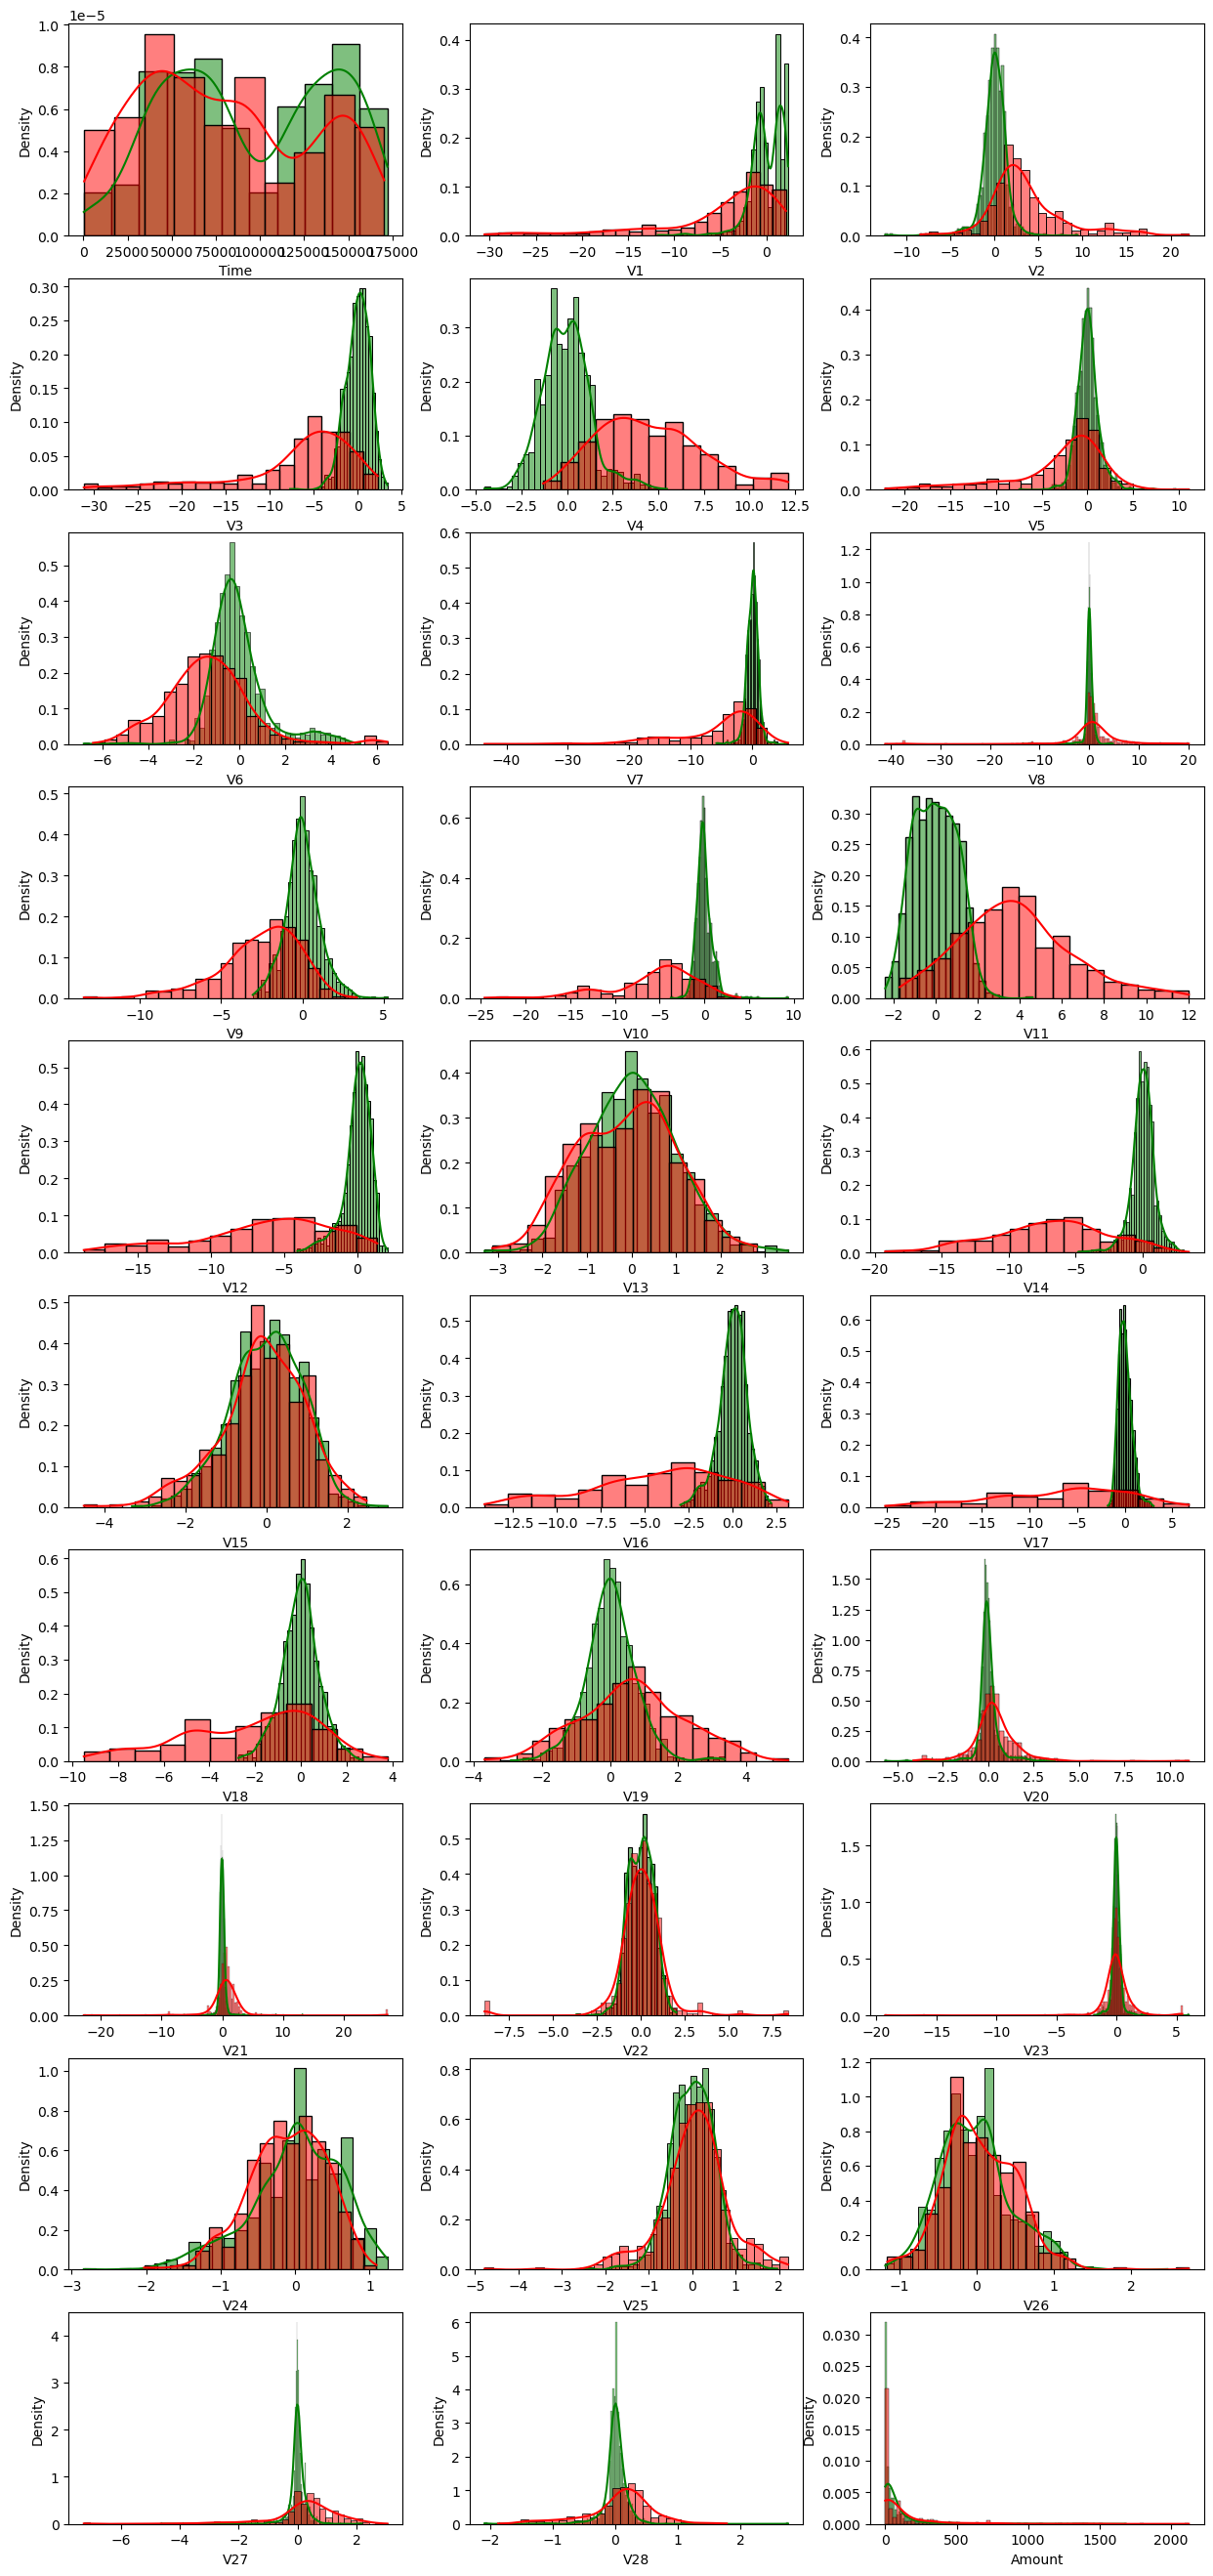

In [6]:
data_auth_plot = data_auth.sample(1000)
features = data.drop(columns='Class', errors='ignore' ).columns

fig = plt.figure(figsize=(15, 40))

for i, column in enumerate(features):    
    plt.subplot(12, 3, i+1)
    sns.histplot(data=data_auth_plot, x=column, kde=True, stat='density', color='green')
    sns.histplot(data=data_fraud, x=column, kde=True, stat='density', color='red')
           
plt.show()

Let's select several features that differ most between classes to check how the model metrics change when the dimensionality is reduced.

In [7]:
selected_features = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [8]:
data.corr(method='spearman')['Class'].abs().sort_values(ascending=False)*100 

Class     100.000000
V14         6.461349
V4          6.304529
V12         6.287007
V11         6.014300
V10         5.956387
V3          5.927838
V2          5.106178
V16         4.993630
V9          4.949880
V7          4.830790
V17         4.433513
V1          4.242350
V6          3.840985
V21         3.544206
V18         3.487225
V5          3.014747
V27         2.831122
V8          2.270629
V19         2.254635
V20         2.157410
V28         2.041712
Time        1.169187
V24         0.918789
Amount      0.833885
V26         0.546628
V23         0.501694
V25         0.468220
V13         0.365332
V15         0.284078
V22         0.208256
Name: Class, dtype: float64

The apparent low correlation between features and the target variable might be an artifact of severe class imbalance. To verify this hypothesis, we will balance the classes and re-evaluate the relationships.

In [9]:
data_balanced = pd.concat([data_auth.sample(492), data_fraud], axis=0)
data_balanced.corr(method='spearman')['Class'].abs().sort_values(ascending=False)*100 

Class     100.000000
V14        78.075573
V4         75.430957
V12        75.413068
V10        72.695467
V11        72.339847
V3         71.305899
V2         62.057612
V16        60.160730
V7         58.880638
V9         58.214475
V17        53.477635
V1         52.006496
V6         46.484714
V21        42.728157
V18        39.829526
V5         35.713770
V27        34.068040
V19        27.740566
V28        26.241521
V8         26.109147
V20        24.441236
Time       15.714576
V24        10.414608
Amount      9.742287
V26         6.024803
V23         5.961120
V25         5.896006
V15         3.730083
V13         3.053187
V22         0.173159
Name: Class, dtype: float64

Let us evaluate the statistical significance of the differences in the average values ​​of features between classes.

In [10]:
features = []
t_statistics = []
p_values = []

for feature in data.drop(columns='Class').columns:
    sample1 = data[data['Class'] == 0][feature]
    sample2 = data[data['Class'] == 1][feature]
    t_stat, p_value = stats.ttest_ind(sample1, sample2)
    features.append(feature)
    t_statistics.append(abs(t_stat))
    p_values.append(p_value)

features_t_stat = pd.DataFrame({'features': features, 't_stat': t_statistics, 'p_value': p_values})   
features_t_stat = features_t_stat.sort_values(by='t_stat', ascending=False)
features_t_stat

,features,t_stat,p_value
17,V17,184.334393,0.000000e+00
14,V14,169.397603,0.000000e+00
12,V12,144.047986,0.000000e+00
10,V10,118.566353,0.000000e+00
16,V16,106.973592,0.000000e+00
3,V3,104.950028,0.000000e+00
7,V7,101.733010,0.000000e+00
11,V11,83.662148,0.000000e+00
4,V4,71.859809,0.000000e+00
18,V18,59.869697,0.000000e+00


## Conclusions
Although the features show strong separability (26 out of 30 features have statistically significant differences between classes), the core issue of this dataset is extreme class imbalance. This causes models to struggle with correct identification of the minority class (class 1), as they tend to optimize predictions for the dominant class, despite clear differences in feature characteristics.

# 1. Unsupervised Learning

## 1.1. Isolation Forest

Builds multiple isolation trees by randomly selecting features and split thresholds. Anomalies, as rare points, are isolated faster (require fewer splits), reflected in their shorter average path length in trees. Anomaly score is normalized path length: closer to 1 indicates higher anomaly probability. Efficient for high-dimensional data (complexity ~O(n)), robust to noise, no distribution assumptions. Limitations: struggles with clustered anomalies and overlapping classes.

### 1.1.1. 29 features

Functions for visualizing metrics, graphics and finding the optimal classification threshold.

In [11]:
def show_metrics(y_test, pred):
    print("\nTEST RESULTS:")
    print('=' * 16)
    print('Confusion Matrix:')
    print('=' * 16)
    print(confusion_matrix(y_test, pred))
    print('=' * 16)
    print(f'Precision: {precision_score(y_test, pred):.2f}')
    print(f'Recall: {recall_score(y_test, pred):.2f}')
    print('=' * 16)
    print(f'F1 Score: {f1_score(y_test, pred):.2f}')


def show_graphics(y_test, test_loss, threshold):   
    fraud_indices = np.where(y_test == 1)[0]
    non_fraud_indices = np.where(y_test == 0)[0]
    
    plt.hist(test_loss[fraud_indices], bins=50, alpha=0.5, label='Fraud')
    plt.hist(test_loss[non_fraud_indices], bins=50, alpha=0.5, label='Normal')
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Count')
    plt.legend()
    plt.yscale('log')
    plt.show()    


def find_optimal_threshold(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        test_recon = model(torch.FloatTensor(X_val))
        val_loss = torch.mean((test_recon - torch.FloatTensor(X_val))**2, dim=1).numpy()
    
    thresholds = np.linspace(0, 4, 500)
    best_f1 = 0
    best_thresh = 0
    
    for thresh in thresholds:
        preds = (val_loss > thresh).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    return best_thresh, best_f1    

In [12]:
scaler = StandardScaler()

X = data.drop(columns= ['Class', 'Time'])
y = data['Class']
X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((227845, 29), (28481, 29), (28481, 29), (227845,), (28481,), (28481,))

In [13]:
iso_forest = IsolationForest(contamination=0.001727, random_state=42)   
iso_forest.fit(X_train)
pred = iso_forest.predict(X_test)
pred = [1 if x == -1 else 0 for x in pred]  

show_metrics(y_test, pred)    


TEST RESULTS:
Confusion Matrix:
[[28397    35]
 [   32    17]]
Precision: 0.33
Recall: 0.35
F1 Score: 0.34


### 1.1.2. 8 features

In [14]:
X = data[selected_features]
y = data['Class']
X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((227845, 8), (28481, 8), (28481, 8), (227845,), (28481,), (28481,))

In [15]:
iso_forest = IsolationForest(contamination=0.001727, random_state=101)   
iso_forest.fit(X_train)
pred = iso_forest.predict(X_test)
pred = [1 if x == -1 else 0 for x in pred]

show_metrics(y_test, pred) 


TEST RESULTS:
Confusion Matrix:
[[28412    20]
 [   13    36]]
Precision: 0.64
Recall: 0.73
F1 Score: 0.69


## 1.2. Autoencoder

Neural network with encoder (compresses data into latent space) and decoder (reconstructs data). Trained to minimize reconstruction error (MSE). Anomalies are detected via high reconstruction error, as rare patterns are poorly reconstructed. Variants: VAE (probabilistic latent space) or LSTM-autoencoder (for time series). Requires careful architecture tuning and regularization.

### This autoencoder has a symmetric encoder-decoder architecture:

##### Encoder:

Changes dimensionality from input_dim (29 features) to 128 → 64 neurons.
Each layer includes BatchNorm (stabilizes training), LeakyReLU (prevents dead neurons), and Dropout (p=0.2, against overfitting).

##### Decoder:

Reconstructs data from latent space (64 → 128 → original dimension).
Uses BatchNorm and LeakyReLU, but no activation at the output (to preserve data scale).

##### Key Features:

Network depth: 4 fully connected layers (2 encoder, 2 decoder).
Regularization: Dropout on all layers except the output.
Loss function: MSE (compares input and reconstruction).
Optimization: Adam with lr=1e-3.
Anomaly detection: Higher reconstruction error indicates higher anomaly likelihood.

### Validation & Early Stopping

#### Validation Process:

After each training epoch, the model is evaluated on the validation set (X_val, y_val).
The find_optimal_threshold function converts reconstruction error (MSE) to binary labels by:

Calculating MSE for all validation objects.
Iterating through threshold candidates (e.g., 0 to 4).
Selecting the threshold that maximizes F1-score between predictions and true labels.

F1-score is prioritized due to class imbalance (anomalies are the minority class).

#### Early Stopping:

Monitors validation F1-score. Training stops if no improvement is seen for patience=10 epochs.
Workflow:

best_f1 tracks the highest F1 value.
If current_f1 > best_f1:

Update best_f1.
Reset epochs_without_improvement counter.
Save model weights (best_autoencoder.pth).

Otherwise, increment the counter and stop training when patience is reached.

#### Benefits:

Prevents overfitting.
Saves computational resources.

### 1.2.1. 29 features

In [16]:
X = data.drop(['Class', 'Time'], axis=1)  
y = data['Class'].values

X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

train_tensor = torch.FloatTensor(X_train) 
test_tensor = torch.FloatTensor(X_test)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           generator=torch.Generator().manual_seed(42), 
                                           drop_last=True
                                           )
 
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
 
patience = 10
best_f1 = -np.inf
epochs_without_improvement = 0
best_model_path = 'best_autoencoder.pth'
loss_history = []

for epoch in range(100):  
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    current_threshold, current_f1 = find_optimal_threshold(model, X_val, y_val)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best F1: {best_f1:.4f} (saved)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement ({epochs_without_improvement}/{patience})")
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {current_f1:.4f}, Threshold: {current_threshold:.4f}')
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_model_path))

New best F1: 0.3333 (saved)
Epoch 1, Loss: 0.3344, Val F1: 0.3333, Threshold: 2.3567
New best F1: 0.3579 (saved)
Epoch 2, Loss: 0.2494, Val F1: 0.3579, Threshold: 1.6914
No improvement (1/10)
Epoch 3, Loss: 0.2247, Val F1: 0.3434, Threshold: 1.5872
New best F1: 0.4186 (saved)
Epoch 4, Loss: 0.2146, Val F1: 0.4186, Threshold: 2.0200
No improvement (1/10)
Epoch 5, Loss: 0.2082, Val F1: 0.4096, Threshold: 2.6613
No improvement (2/10)
Epoch 6, Loss: 0.2038, Val F1: 0.3145, Threshold: 0.7134
No improvement (3/10)
Epoch 7, Loss: 0.2014, Val F1: 0.3529, Threshold: 0.8497
No improvement (4/10)
Epoch 8, Loss: 0.1974, Val F1: 0.3387, Threshold: 0.8016
No improvement (5/10)
Epoch 9, Loss: 0.1973, Val F1: 0.3206, Threshold: 0.8818
No improvement (6/10)
Epoch 10, Loss: 0.1939, Val F1: 0.3158, Threshold: 0.8898
New best F1: 0.4198 (saved)
Epoch 11, Loss: 0.1914, Val F1: 0.4198, Threshold: 1.5952
No improvement (1/10)
Epoch 12, Loss: 0.1910, Val F1: 0.3269, Threshold: 0.9058
No improvement (2/10)
Epo

<All keys matched successfully>

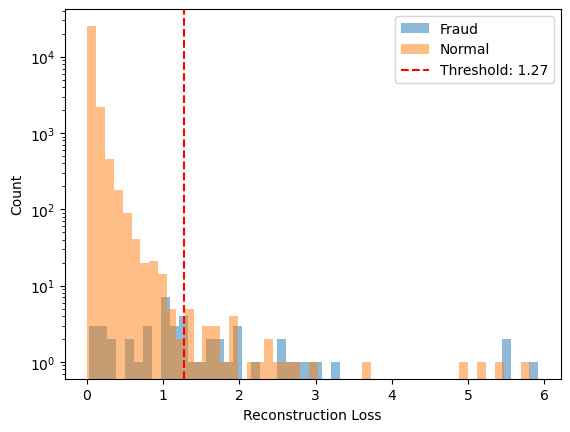


TEST RESULTS:
Confusion Matrix:
[[28402    30]
 [   26    23]]
Precision: 0.43
Recall: 0.47
F1 Score: 0.45


In [17]:
threshold, best_f1 = find_optimal_threshold(model, X_val, y_val) 

test_predictions = []
model.eval() 
with torch.no_grad():
    reconstructions = model(test_tensor) 
    test_loss = np.array([criterion(reconstructions[i], test_tensor[i]).item() 
                        for i in range(len(test_tensor))]) 
    
test_predictions = (test_loss > threshold).astype(int)
 
show_graphics(y_test, test_loss, threshold)
show_metrics(y_test, test_predictions)    

### 1.2.2. 8 features

The autoencoder architecture is adjusted for 8 input features:

Encoder: 8 → 64 → 32 (neurons halved).
Decoder: 32 → 64 → 8.
BatchNorm, LeakyReLU, and Dropout are retained. Reduced parameters prevent overfitting on low-dimensional data.

In [18]:
X =  data[selected_features]
y = data['Class'].values

X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

train_tensor = torch.FloatTensor(X_train)
test_tensor = torch.FloatTensor(X_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           generator=torch.Generator().manual_seed(42), 
                                           drop_last=True
                                           )


class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), 
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.18),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.18),
            nn.Linear(64, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()    

patience = 10
best_f1 = -np.inf
epochs_without_improvement = 0
best_model_path = 'best_autoencoder.pth'
loss_history = []

for epoch in range(100):  
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    current_threshold, current_f1 = find_optimal_threshold(model, X_val, y_val)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best F1: {best_f1:.4f} (saved)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement ({epochs_without_improvement}/{patience})")
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {current_f1:.4f}, Threshold: {current_threshold:.4f}')
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_model_path))

New best F1: 0.6742 (saved)
Epoch 1, Loss: 0.1440, Val F1: 0.6742, Threshold: 0.5772
No improvement (1/10)
Epoch 2, Loss: 0.1005, Val F1: 0.4928, Threshold: 0.9218
No improvement (2/10)
Epoch 3, Loss: 0.0924, Val F1: 0.6118, Threshold: 0.6092
No improvement (3/10)
Epoch 4, Loss: 0.0884, Val F1: 0.5753, Threshold: 0.7936
No improvement (4/10)
Epoch 5, Loss: 0.0847, Val F1: 0.5435, Threshold: 0.4890
New best F1: 0.7600 (saved)
Epoch 6, Loss: 0.0846, Val F1: 0.7600, Threshold: 0.5852
New best F1: 0.8211 (saved)
Epoch 7, Loss: 0.0811, Val F1: 0.8211, Threshold: 0.6493
No improvement (1/10)
Epoch 8, Loss: 0.0815, Val F1: 0.6250, Threshold: 0.5451
No improvement (2/10)
Epoch 9, Loss: 0.0798, Val F1: 0.8163, Threshold: 1.1303
No improvement (3/10)
Epoch 10, Loss: 0.0787, Val F1: 0.5926, Threshold: 0.3126
No improvement (4/10)
Epoch 11, Loss: 0.0786, Val F1: 0.6263, Threshold: 0.3206
No improvement (5/10)
Epoch 12, Loss: 0.0784, Val F1: 0.8125, Threshold: 1.4269
No improvement (6/10)
Epoch 13,

<All keys matched successfully>

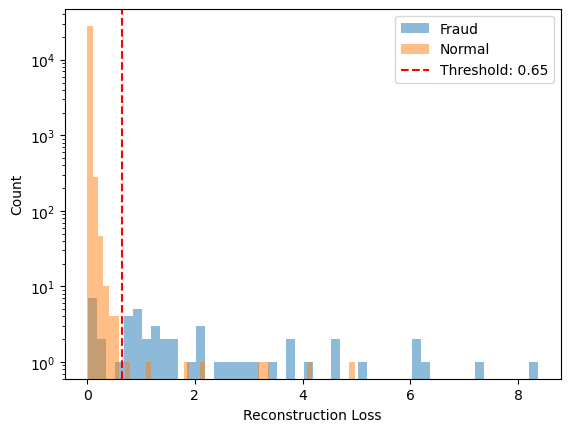


TEST RESULTS:
Confusion Matrix:
[[28424     8]
 [   10    39]]
Precision: 0.83
Recall: 0.80
F1 Score: 0.81


In [19]:
threshold, best_f1 = find_optimal_threshold(model, X_val, y_val)

test_predictions = []
model.eval()
with torch.no_grad():
    reconstructions = model(test_tensor)
    test_loss = np.array([criterion(reconstructions[i], test_tensor[i]).item()
                        for i in range(len(test_tensor))])
    
test_predictions = (test_loss > threshold).astype(int)

show_graphics(y_test, test_loss, threshold)
show_metrics(y_test, test_predictions)    

## 1.3. Conclusions

In [20]:
print('Unsupervised learning, F1_score:')
pd.DataFrame({'Method': ['Isolation Forest', 'Autoencoder'], '29 features (F1_score)': [0.34, 0.45],  '8 features (F1_score)': [0.69,0.81]})

Unsupervised learning, F1_score:


,Method,29 features (F1_score),8 features (F1_score)
0,Isolation Forest,0.34,0.69
1,Autoencoder,0.45,0.81


The autoencoder outperforms the isolation forest. Reducing features to 8 most informative ones dramatically improves both models: the autoencoder’s F1 increases by 80%, while the isolation forest’s F1 more than doubles.

# 2. Semi-supervised learning

## 2.1. Multivariate Gaussian distribution

Assumes "normal" data follows a multivariate normal distribution. Estimates parameters: mean vector (μ) and covariance matrix (Σ). Anomalies are flagged if p(x)<ϵ, where ϵ is a threshold. Fast (O(n^3)) and interpretable, but sensitive to non-Gaussian data and outliers. Use robust covariance estimators (e.g., Minimum Covariance Determinant) to mitigate this.

### 2.1.1. 29 features

In [21]:
X = data.drop(columns= ['Class', 'Time'])
y = data['Class']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((227451, 29), (28481, 29), (28481, 29), (227451,), (28481,), (28481,))

In [22]:
mu = X_train.mean(axis=0).values
sigma = X_train.cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(X_val[y_val == 0].values))) 
print(np.median(model.logpdf(X_val[y_val == 1].values))) 

-35.527744794644306
-898.7397606645881


In [23]:
tresholds = np.linspace(-2000,-100, 150)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(X_val.values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=y_val.values),
                 precision_score(y_pred=y_hat, y_true=y_val.values),
                 f1_score(y_pred=y_hat, y_true=y_val.values)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.5454545454545454 122


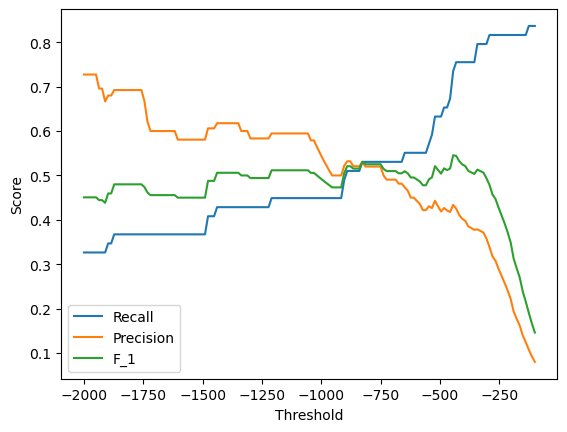

In [24]:
plt.plot(tresholds, scores[:, 0], label='Recall')
plt.plot(tresholds, scores[:, 1], label='Precision')
plt.plot(tresholds, scores[:, 2], label='F_1')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [25]:
final_tresh = tresholds[scores[:, 2].argmax()]
pred = (model.logpdf(X_test.values) < final_tresh).astype(int)

show_metrics(y_test, pred)    


TEST RESULTS:
Confusion Matrix:
[[28389    43]
 [   16    33]]
Precision: 0.43
Recall: 0.67
F1 Score: 0.53


### 2.1.2. 8 features

In [26]:
X =  data[selected_features]
y = data['Class']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((227451, 8), (28481, 8), (28481, 8), (227451,), (28481,), (28481,))

In [27]:
mu = X_train.mean(axis=0).values
sigma = X_train.cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(X_val[y_val == 0].values))) 
print(np.median(model.logpdf(X_val[y_val == 1].values))) 

-9.921189650479935
-325.9567578557285


In [28]:
tresholds = np.linspace(-600, 100, 150)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(X_val.values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=y_val.values),
                 precision_score(y_pred=y_hat, y_true=y_val.values),
                 f1_score(y_pred=y_hat, y_true=y_val.values)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7959183673469388 97


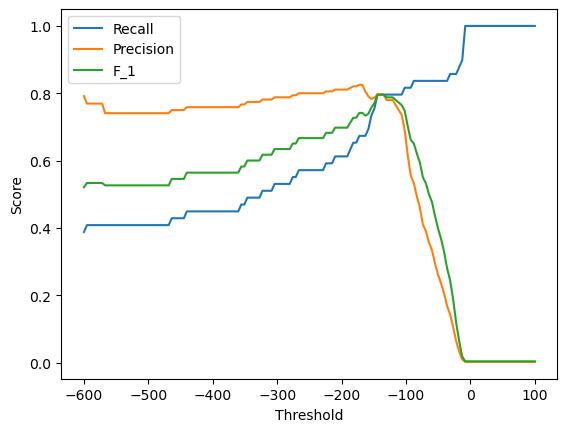

In [29]:
plt.plot(tresholds, scores[:, 0], label='Recall')
plt.plot(tresholds, scores[:, 1], label='Precision')
plt.plot(tresholds, scores[:, 2], label='F_1')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [30]:
final_tresh = tresholds[scores[:, 2].argmax()]
pred = (model.logpdf(X_test.values) < final_tresh).astype(int)

show_metrics(y_test, pred)    


TEST RESULTS:
Confusion Matrix:
[[28422    10]
 [   14    35]]
Precision: 0.78
Recall: 0.71
F1 Score: 0.74


## 2.2. Autoencoder

Autoencoder in Semi-Supervised Setup trained only on normal data, then detects anomalies via reconstruction error.

### 2.2.1. 29 features

In [31]:
X = data.drop(['Class', 'Time'], axis=1)  
y = data['Class'].values

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)
X_train = X_train[y_train == 0]

train_tensor = torch.FloatTensor(X_train) 
test_tensor = torch.FloatTensor(X_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           generator=torch.Generator().manual_seed(42), 
                                           drop_last=True
                                           )

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()    

patience = 10
best_f1 = -np.inf
epochs_without_improvement = 0
best_model_path = 'best_autoencoder.pth'
loss_history = []

for epoch in range(100):  
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    current_threshold, current_f1 = find_optimal_threshold(model, X_val, y_val)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best F1: {best_f1:.4f} (saved)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement ({epochs_without_improvement}/{patience})")
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {current_f1:.4f}, Threshold: {current_threshold:.4f}')
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_model_path))


New best F1: 0.6379 (saved)
Epoch 1, Loss: 0.3175, Val F1: 0.6379, Threshold: 3.7675
New best F1: 0.6491 (saved)
Epoch 2, Loss: 0.2387, Val F1: 0.6491, Threshold: 3.5992
New best F1: 0.7255 (saved)
Epoch 3, Loss: 0.2163, Val F1: 0.7255, Threshold: 3.6794
No improvement (1/10)
Epoch 4, Loss: 0.2059, Val F1: 0.7080, Threshold: 2.2445
New best F1: 0.7429 (saved)
Epoch 5, Loss: 0.2007, Val F1: 0.7429, Threshold: 2.7094
New best F1: 0.7500 (saved)
Epoch 6, Loss: 0.1969, Val F1: 0.7500, Threshold: 2.6293
No improvement (1/10)
Epoch 7, Loss: 0.1918, Val F1: 0.7477, Threshold: 2.2685
No improvement (2/10)
Epoch 8, Loss: 0.1896, Val F1: 0.7027, Threshold: 2.2846
No improvement (3/10)
Epoch 9, Loss: 0.1880, Val F1: 0.7027, Threshold: 1.5150
No improvement (4/10)
Epoch 10, Loss: 0.1873, Val F1: 0.6435, Threshold: 1.8597
No improvement (5/10)
Epoch 11, Loss: 0.1851, Val F1: 0.6916, Threshold: 1.6273
No improvement (6/10)
Epoch 12, Loss: 0.1849, Val F1: 0.6863, Threshold: 1.4749
No improvement (7/1

<All keys matched successfully>

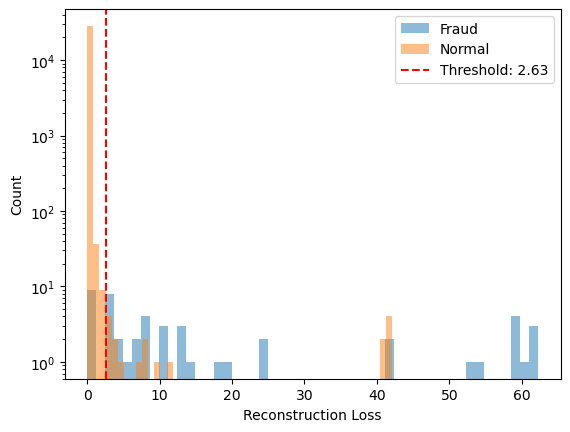


TEST RESULTS:
Confusion Matrix:
[[28414    18]
 [    9    40]]
Precision: 0.69
Recall: 0.82
F1 Score: 0.75


In [32]:
threshold, best_f1 = find_optimal_threshold(model, X_val, y_val)

model.eval()
with torch.no_grad():
    reconstructions = model(test_tensor)
    test_loss = np.array([criterion(reconstructions[i], test_tensor[i]).item()
                        for i in range(len(test_tensor))])
    
test_predictions = (test_loss > threshold).astype(int)

show_graphics(y_test, test_loss, threshold)
show_metrics(y_test, test_predictions)

### 2.2.2. 8 features

In [33]:
X = data[selected_features]
y = data['Class'].values

X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)
X_train = X_train[y_train == 0]

train_tensor = torch.FloatTensor(X_train)
test_tensor = torch.FloatTensor(X_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           generator=torch.Generator().manual_seed(42), 
                                           drop_last=True
                                           )

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), 
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.18),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.18),
            nn.Linear(64, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()    

patience = 10
best_f1 = -np.inf
epochs_without_improvement = 0
best_model_path = 'best_autoencoder.pth'
loss_history = []

for epoch in range(100):  
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    current_threshold, current_f1 = find_optimal_threshold(model, X_val, y_val)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best F1: {best_f1:.4f} (saved)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement ({epochs_without_improvement}/{patience})")
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {current_f1:.4f}, Threshold: {current_threshold:.4f}')
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_model_path))

New best F1: 0.6889 (saved)
Epoch 1, Loss: 0.1150, Val F1: 0.6889, Threshold: 0.4569
New best F1: 0.7234 (saved)
Epoch 2, Loss: 0.0882, Val F1: 0.7234, Threshold: 0.3126
New best F1: 0.7660 (saved)
Epoch 3, Loss: 0.0829, Val F1: 0.7660, Threshold: 0.4649
No improvement (1/10)
Epoch 4, Loss: 0.0791, Val F1: 0.6316, Threshold: 1.2745
No improvement (2/10)
Epoch 5, Loss: 0.0768, Val F1: 0.7010, Threshold: 0.3607
New best F1: 0.7800 (saved)
Epoch 6, Loss: 0.0750, Val F1: 0.7800, Threshold: 0.2645
New best F1: 0.7835 (saved)
Epoch 7, Loss: 0.0735, Val F1: 0.7835, Threshold: 0.4008
No improvement (1/10)
Epoch 8, Loss: 0.0725, Val F1: 0.7527, Threshold: 0.2966
No improvement (2/10)
Epoch 9, Loss: 0.0721, Val F1: 0.7789, Threshold: 0.4168
No improvement (3/10)
Epoch 10, Loss: 0.0717, Val F1: 0.6977, Threshold: 0.3126
No improvement (4/10)
Epoch 11, Loss: 0.0709, Val F1: 0.4634, Threshold: 0.7295
No improvement (5/10)
Epoch 12, Loss: 0.0708, Val F1: 0.7447, Threshold: 0.3768
No improvement (6/1

<All keys matched successfully>

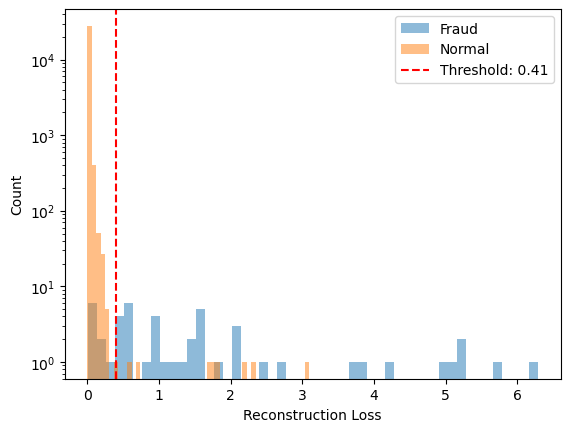


TEST RESULTS:
Confusion Matrix:
[[28423     9]
 [   10    39]]
Precision: 0.81
Recall: 0.80
F1 Score: 0.80


In [34]:
threshold, best_f1 = find_optimal_threshold(model, X_val, y_val)

model.eval()
with torch.no_grad():
    reconstructions = model(test_tensor)
    test_loss = np.array([criterion(reconstructions[i], test_tensor[i]).item()
                        for i in range(len(test_tensor))])
    
test_predictions = (test_loss > threshold).astype(int)

show_graphics(y_test, test_loss, threshold)
show_metrics(y_test, test_predictions)

## 2.3. Conclusions

In [35]:
print('Semi-supervised learning, F1_score:')
pd.DataFrame({'Method': ['Multivariate normal', 'Autoencoder'], '29 features (F1_score)': [0.53, 0.75],  '8 features (F1_score)': [0.74,0.80]})

Semi-supervised learning, F1_score:


,Method,29 features (F1_score),8 features (F1_score)
0,Multivariate normal,0.53,0.74
1,Autoencoder,0.75,0.80


The semi-supervised autoencoder substantially outperforms the multivariate Gaussian method. Feature reduction to 8 improves F1-score for both models: Multivariate normal achieves a 39% increase, while the autoencoder maintains dominance with F1=0.80, demonstrating robustness to dimensionality reduction.

# 3. Supervised Learning

## 3.1. Random Forest

Ensemble of decision trees trained on labeled data ("normal" vs "anomaly"). Each tree uses random subsets of data and features. Final prediction is majority voting.
In our dataset, it achieved F1 = 0.86–0.89 due to:

Robustness to class imbalance.

Ability to capture non-linear relationships through tree combinations.

Overfitting reduction via bagging (bootstrap aggregation).

### 3.1.1. 29 features

In [36]:
X = data.drop(['Class', 'Time'], axis=1) 
y = data['Class']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

In [37]:
clf = RandomForestClassifier(n_jobs=4, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=10,
                             verbose=False)

clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=42,
                       verbose=False)

In [38]:
pred = clf.predict(X_test)

show_metrics(y_test, pred)    


TEST RESULTS:
Confusion Matrix:
[[28429     3]
 [   10    39]]
Precision: 0.93
Recall: 0.80
F1 Score: 0.86


### 3.1.2. 8 features

In [39]:
X = data[selected_features]
y = data['Class']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

In [40]:
clf = RandomForestClassifier(n_jobs=4, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=10,
                             verbose=False)

clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=42,
                       verbose=False)

In [41]:
pred = clf.predict(X_test)

show_metrics(y_test, pred)


TEST RESULTS:
Confusion Matrix:
[[28430     2]
 [    8    41]]
Precision: 0.95
Recall: 0.84
F1 Score: 0.89


## 3.2. Neural Network Classifier

Function for determining the classification threshold

In [42]:
def find_optimal_threshold_classifier(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        probs = model(torch.FloatTensor(X_val)).squeeze().numpy()
    
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_thresh = 0
    
    for thresh in thresholds:
        preds = (probs > thresh).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    return best_thresh, best_f1

### 3.2.1. 29 features

In [43]:
X = data.drop(['Class', 'Time'], axis=1)  
y = data['Class'].values

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

train_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           generator=torch.Generator().manual_seed(42), 
                                           drop_last=True
                                           )

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = Classifier(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.BCELoss()  

patience = 10
best_f1 = -np.inf
epochs_without_improvement = 0
best_model_path = 'best_autoencoder.pth'
loss_history = []
best_threshold = None

for epoch in range(100):  
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        inputs, labels = batch  
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs.squeeze(), labels)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    current_threshold, current_f1 = find_optimal_threshold_classifier(model, X_val, y_val)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = current_threshold
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best F1: {best_f1:.4f} (saved)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement ({epochs_without_improvement}/{patience})")
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {current_f1:.4f}, Threshold: {current_threshold:.4f}')
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_model_path))

New best F1: 0.8163 (saved)
Epoch 1, Loss: 0.0685, Val F1: 0.8163, Threshold: 0.7273
New best F1: 0.8247 (saved)
Epoch 2, Loss: 0.0040, Val F1: 0.8247, Threshold: 0.8384
No improvement (1/10)
Epoch 3, Loss: 0.0032, Val F1: 0.8247, Threshold: 0.8586
New best F1: 0.8283 (saved)
Epoch 4, Loss: 0.0029, Val F1: 0.8283, Threshold: 0.4848
New best F1: 0.8317 (saved)
Epoch 5, Loss: 0.0027, Val F1: 0.8317, Threshold: 0.3838
New best F1: 0.8333 (saved)
Epoch 6, Loss: 0.0025, Val F1: 0.8333, Threshold: 0.9192
No improvement (1/10)
Epoch 7, Loss: 0.0025, Val F1: 0.8247, Threshold: 0.8283
No improvement (2/10)
Epoch 8, Loss: 0.0024, Val F1: 0.8247, Threshold: 0.6667
No improvement (3/10)
Epoch 9, Loss: 0.0024, Val F1: 0.8283, Threshold: 0.3838
No improvement (4/10)
Epoch 10, Loss: 0.0022, Val F1: 0.8235, Threshold: 0.3535
No improvement (5/10)
Epoch 11, Loss: 0.0022, Val F1: 0.8235, Threshold: 0.3939
No improvement (6/10)
Epoch 12, Loss: 0.0020, Val F1: 0.8222, Threshold: 0.8485
New best F1: 0.8367

<All keys matched successfully>

In [44]:
threshold=best_threshold

model.eval()
with torch.no_grad():
    outputs = model(torch.FloatTensor(X_test))
    predictions = (outputs.squeeze() > threshold).float()
        
show_metrics(y_test, predictions)    


TEST RESULTS:
Confusion Matrix:
[[28428     4]
 [    7    42]]
Precision: 0.91
Recall: 0.86
F1 Score: 0.88


### 3.2.2. 8 features

In [45]:
X = data[selected_features]
y = data['Class'].values

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_sc, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

train_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_tensor, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           generator=torch.Generator().manual_seed(42), 
                                           drop_last=True
                                           )

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )    
  
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = Classifier(input_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4) #-4

criterion = nn.BCELoss()  

patience = 10
best_f1 = -np.inf
epochs_without_improvement = 0
best_model_path = 'best_autoencoder.pth'
loss_history = []
best_threshold = None

for epoch in range(100):  
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        inputs, labels = batch  
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs.squeeze(), labels)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    
    current_threshold, current_f1 = find_optimal_threshold_classifier(model, X_val, y_val)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = current_threshold
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best F1: {best_f1:.4f} (saved)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement ({epochs_without_improvement}/{patience})")
    
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val F1: {current_f1:.4f}, Threshold: {current_threshold:.4f}')
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(torch.load(best_model_path))

New best F1: 0.8247 (saved)
Epoch 1, Loss: 0.2541, Val F1: 0.8247, Threshold: 0.5758
No improvement (1/10)
Epoch 2, Loss: 0.0135, Val F1: 0.8163, Threshold: 0.4646
No improvement (2/10)
Epoch 3, Loss: 0.0043, Val F1: 0.8247, Threshold: 0.6465
New best F1: 0.8333 (saved)
Epoch 4, Loss: 0.0035, Val F1: 0.8333, Threshold: 0.7677
No improvement (1/10)
Epoch 5, Loss: 0.0034, Val F1: 0.8333, Threshold: 0.8384
No improvement (2/10)
Epoch 6, Loss: 0.0033, Val F1: 0.8333, Threshold: 0.8485
No improvement (3/10)
Epoch 7, Loss: 0.0033, Val F1: 0.8125, Threshold: 0.5960
No improvement (4/10)
Epoch 8, Loss: 0.0033, Val F1: 0.8247, Threshold: 0.6869
No improvement (5/10)
Epoch 9, Loss: 0.0033, Val F1: 0.8211, Threshold: 0.6970
No improvement (6/10)
Epoch 10, Loss: 0.0033, Val F1: 0.8333, Threshold: 0.7980
No improvement (7/10)
Epoch 11, Loss: 0.0032, Val F1: 0.8333, Threshold: 0.8081
No improvement (8/10)
Epoch 12, Loss: 0.0032, Val F1: 0.8247, Threshold: 0.6263
No improvement (9/10)
Epoch 13, Loss:

<All keys matched successfully>

In [46]:
threshold=best_threshold 

model.eval()
with torch.no_grad():
    outputs = model(torch.FloatTensor(X_test))
    predictions = (outputs.squeeze() > threshold).float()
        
show_metrics(y_test, predictions)    


TEST RESULTS:
Confusion Matrix:
[[28424     8]
 [    9    40]]
Precision: 0.83
Recall: 0.82
F1 Score: 0.82


## 3.3. Conclusions

In [47]:
print('Supervised learning, F1_score:')
pd.DataFrame({'Method': ['Random Forest Classifier', 'Neural Network Classifier'], '29 features (F1_score)': [0.86, 0.88],  '8 features (F1_score)': [0.89,0.82]})

Supervised learning, F1_score:


,Method,29 features (F1_score),8 features (F1_score)
0,Random Forest Classifier,0.86,0.89
1,Neural Network Classifier,0.88,0.82


Random Forest shows an F1-score increase (from 0.86 to 0.89, +3.5%) with feature reduction, while the Neural Network classifier declines in performance (from 0.88 to 0.82, -6.8%). This highlights Random Forest's robustness to dimensionality reduction, whereas the neural network likely requires more informative features to maintain its accuracy

# Conclusions

Neural methods (autoencoders) have demonstrated versatility by achieving high effectiveness across all learning paradigms:

- Unsupervised: F1 = 0.81 (8 features),
- Semi-supervised: F1 = 0.80 (8 features),
- Supervised: F1 = 0.88 (29 features).

Random Forest, in turn, has proven to be the optimal choice for supervised learning (F1 = 0.89) but is not applicable in other learning paradigms. The key success factor is feature quality: reducing their number to 8 improved the metrics for most models.